#1. Import các thư viện cần thiết cho việc build model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import re

# 2. Chuẩn bị và tiền xử lý dữ liệu

##2.1 Đọc tập dữ liệu train đã được tiền xử lý


In [2]:
# df = pd.read_csv("articles_dataset_clean.csv", index_col=0)
df = pd.read_csv("../train_data/processed/articles_dataset_clean.csv", index_col=0)
df

Title  \
0                           Cháy lớn quán bar ở Đồng Nai   
1      Dùng ngân sách Trung ương xây nhà mới cho ngườ...   
2          6 ôtô tông liên hoàn trên cao tốc Trung Lương   
3      Quân nhân Việt - Ấn diễn tập phá mìn, cứu hộ đ...   
4      Khởi công mở rộng cao tốc TP HCM - Trung Lương...   
...                                                  ...   
14577  Đang bay trên đỉnh núi, dù lượn của người đàn ...   
14578  Quán xôi 3 đời mẹ truyền con nối ở TPHCM đắt k...   
14579  Bên trong ‘trận địa’ pháo hoa quốc tế Đà Nẵng ...   
14580  Lễ hội dâng đăng độc đáo mừng Lễ Vía Bà tại nú...   
14581  Chinh phục 'nóc nhà thế giới' 31 lần, người đà...   

                                             Description Category    Platfrom  \
0      Lửa bùng lên ở quán bar, karaoke rộng hơn 300 ...  thoi-su   vnexpress   
1      Thủ tướng giao Bộ Tài chính đề xuất sử dụng ng...  thoi-su   vnexpress   
2      Sáu ôtô va chạm liên hoàn trên cao tốc TP HCM ...  thoi-su   vnexpress   
3      Trải qua ba tình huống thực binh, quân nhân Vi...  thoi-su   vnexpress   
4      Tuyến cao tốc dài gần 100 km nối TP HCM với mi...  thoi-su   vnexpress   
...                                                  ...      ...         ...   
14577  Dù đã có kinh nghiệm chơi dù lượn lâu năm, son...  du-lich  vietnamnet   
14578  Sau khi lọt vào danh sách Michelin Selected (n...  du-lich  vietnamnet   
14579  Trước thềm đêm khai mạc Lễ hội pháo hoa quốc t...  du-lich  vietnamnet   
14580  Từ ngày 30/5 - 1/6/2025 (nhằm ngày 4 - 6/5 âm ...  du-lich  vietnamnet   
14581  Được mệnh danh là "người đàn ông của Everest",...  du-lich  vietnamnet   

             Area                                                URL  
0             Nan  https://vnexpress.net/chay-lon-quan-bar-o-dong...  
1             Nan  https://vnexpress.net/dung-ngan-sach-trung-uon...  
2        Tây Ninh  https://vnexpress.net/6-oto-tong-lien-hoan-tre...  
3          Hà Nội  https://vnexpress.net/quan-nhan-viet-an-dien-t...  
4             Nan  https://vnexpress.net/khoi-cong-mo-rong-cao-to...  
...           ...                                                ...  
14577  Trung Quốc  https://vietnamnet.vn/dang-bay-tren-dinh-nui-d...  
14578         Nan  https://vietnamnet.vn/quan-xoi-3-doi-me-truyen...  
14579         Nan  https://vietnamnet.vn/ben-trong-tran-dia-phao-...  
14580         Nan  https://vietnamnet.vn/le-hoi-dang-dang-doc-dao...  
14581       Nepal  https://vietnamnet.vn/chinh-phuc-noc-nha-the-g...  

[14582 rows x 6 columns]

##2.2 Chuẩn bị dữ liệu văn bản

Phương pháp:
*   Gộp cột Title và Description để tăng ngữ cảnh cho văn bản đầu vào.
*   Thêm token <dis> để phân biệt hai phần nội dung.
*   Dữ liệu có dạng (text, label).





In [3]:
data = list(zip(df['Title'] + ' <dis> ' + df['Description'], df['Category']))
print(len(data))

14582


##2.3 Tiền xử lý và chuẩn hóa văn bản
Trong bước này, dữ liệu văn bản được chuẩn hóa nhằm giảm nhiễu cho mô hình học máy.
Các thao tác bao gồm:
- Thay thế các biểu thức ngày tháng bằng token `<date>`
- Thay thế số bằng token `<num>`
- Chuyển văn bản về chữ thường
- Loại bỏ ký tự đặc biệt và khoảng trắng dư thừa

In [4]:
def tokenizer(text):
    return text.split()

def normalize_text(text):
    text = str(text)
    # 1) chuẩn hóa ngày trước (để không bị regex số thay mất)
    # dd/mm/yyyy hoặc d/m/yyyy
    text = re.sub(r'\b\d{1,2}/\d{1,2}/\d{2,4}\b', '<date>', text)

    # mm/yyyy hoặc m/yyyy
    text = re.sub(r'\b\d{1,2}/\d{4}\b', '<date>', text)

    # dd/mm hoặc d/m
    text = re.sub(r'\b\d{1,2}/\d{1,2}\b', '<date>', text)

    # 2) thay mọi số còn lại thành <num>
    text = re.sub(r'\b\d+(\.\d+)?\b', '<num>', text)

    text = text.lower()

    #text = re.sub(r'[^\w\s]', '', text)  # loại tất cả ký tự không phải chữ/số/space
    text = re.sub(r'[^\w\s<>/]', '', text)

    text = re.sub(r'\s+', ' ', text).strip()  # bỏ khoảng trắng thừa

    return text

## 2.4 Áp dụng tiền xử lý cho dữ liệu

Trong bước này, hàm chuẩn hóa văn bản được áp dụng cho toàn bộ tập dữ liệu.
Mỗi mẫu dữ liệu sau xử lý vẫn giữ cấu trúc `(văn bản, nhãn)` nhằm phục vụ
cho các bước huấn luyện mô hình phía sau.

In [5]:
data = [(normalize_text(text[0]), text[1]) for text in data]
print(data)

[('cháy lớn quán bar ở đồng nai <dis> lửa bùng lên ở quán bar karaoke rộng hơn <num> m2 ngừng hoạt động nằm kề cây xăng ở quốc lộ <num> khói bao trùm cả khu vực nhiều người tìm cách thoát thân tối <date>', 'thoi-su'), ('dùng ngân sách trung ương xây nhà mới cho người dân vùng lũ <dis> thủ tướng giao bộ tài chính đề xuất sử dụng nguồn lực từ ngân sách trung ương và phân công một số tỉnh thành hỗ trợ xây nhà mới cho người dân vùng mưa lũ', 'thoi-su'), ('<num> ôtô tông liên hoàn trên cao tốc trung lương <dis> sáu ôtô va chạm liên hoàn trên cao tốc tp hcm trung lương trưa <date> khiến nhiều xe hư hỏng nặng giao thông ùn ứ kéo dài', 'thoi-su'), ('quân nhân việt ấn diễn tập phá mìn cứu hộ động đất <dis> trải qua ba tình huống thực binh quân nhân việt nam ấn độ lần lượt rà phá bom mìn giải tán đám đông tấn công doanh trại và cứu hộ nạn nhân động đất đưa đi cấp cứu bằng trực thăng', 'thoi-su'), ('khởi công mở rộng cao tốc tp hcm trung lương mỹ thuận ngày <date> <dis> tuyến cao tốc dài gần <num

## 2.5 Chia tập dữ liệu huấn luyện và kiểm tra

Tập dữ liệu được chia thành hai phần:
- Tập huấn luyện (train) dùng để huấn luyện mô hình
- Tập kiểm tra (validation) dùng để đánh giá mô hình trong quá trình huấn luyện

Tỷ lệ dữ liệu dành cho tập kiểm tra được đặt là 10%.

In [62]:
val_size = 0.1

train_data, val_data = train_test_split(data, test_size=val_size, shuffle=True, random_state=42)

print(len(train_data), len(val_data))

13123 1459


##2.6 Nạp tập dữ liệu kiểm tra (Test set)

Tập dữ liệu kiểm tra được sử dụng để đánh giá hiệu năng cuối cùng của mô hình
sau khi đã hoàn tất quá trình huấn luyện.  

In [7]:
# test_df = pd.read_csv("articles_dataset_test.csv", index_col=0)
test_df = pd.read_csv("../test_data/articles_dataset_test.csv", index_col=0)
test_df

Title  \
0                            Ba đứa trẻ tử vong dưới hồ   
1          Cháy cửa hàng điện máy ở trung tâm Vĩnh Long   
2                Xe tải tông sập nhà, một người tử vong   
3     Xe buýt, metro ở TP HCM miễn vé ngày Tết Dương...   
4     Phút hoảng loạn khi xe chở đoàn thiện nguyện m...   
...                                                 ...   
1835  Khách Việt thực hiện giấc mơ tuyết trắng ở quê...   
1836  Rừng phong Khe Sanh đổi màu lá, hút khách trek...   
1837                Tuyên Quang tổ chức lễ hội nhảy lửa   
1838  Kỳ nghỉ xáo trộn của khách Tây ở Phú Quốc vì m...   
1839  Bên trong khách sạn U22 Việt Nam lưu trú cho S...   

                                            Description Category   Platfrom  \
0     Ba cháu nhỏ 7 và 8 tuổi tắm ở hồ tưới cà phê g...  thoi-su  vnexpress   
1     Cửa hàng điện máy rộng hàng trăm m2 ở trung tâ...  thoi-su  vnexpress   
2     Xe tải chở gỗ keo tràm đi trên đường tỉnh lộ t...  thoi-su  vnexpress   
3     Xe buýt và tàu điện Bến Thành - Suối Tiên ở TP...  thoi-su  vnexpress   
4     Thấy xe lao dốc sầm sập khi trên đường tới điể...  thoi-su  vnexpress   
...                                                 ...      ...        ...   
1835  Vượt qua cái lạnh âm 17 độ C và 18 tiếng di ch...  du-lich  vnexpress   
1836  Tháng 12, rừng phong hương quanh hồ thủy điện ...  du-lich  vnexpress   
1837  Lễ hội nhảy lửa của người Pà Thẻn tại xã Tân T...  du-lich  vnexpress   
1838  Chi hàng nghìn USD cho chuyến đi đảo ngọc nhưn...  du-lich  vnexpress   
1839  Nhằm tối ưu thể lực, tuyển nam U22 Việt Nam đư...  du-lich  vnexpress   

           Area                                                URL  
0       Đăk Lăk  https://vnexpress.net/ba-dua-tre-tu-vong-duoi-...  
1           NaN  https://vnexpress.net/chay-cua-hang-dien-may-o...  
2     Quảng Trị  https://vnexpress.net/xe-tai-tong-sap-nha-mot-...  
3           NaN  https://vnexpress.net/xe-buyt-metro-o-tp-hcm-m...  
4           NaN  https://vnexpress.net/phut-hoang-loan-khi-xe-c...  
...         ...                                                ...  
1835        NaN  https://vnexpress.net/khach-viet-thuc-hien-gia...  
1836  Quảng Trị  https://vnexpress.net/rung-phong-khe-sanh-doi-...  
1837        NaN  https://vnexpress.net/tuyen-quang-to-chuc-le-h...  
1838        NaN  https://vnexpress.net/ky-nghi-xao-tron-cua-kha...  
1839        NaN  https://vnexpress.net/ben-trong-khach-san-u22-...  

[1840 rows x 6 columns]

##2.7 Kiểm tra trùng lặp giữa train và test

Bước này nhằm phát hiện các bài báo xuất hiện đồng thời
trong cả tập train và tập test. Như ta thấy chỉ có 3 bài báo trùng lặp nên ta sẽ không cần làm gì vì nó chẳng ảnh hưởng nhiều đến việc đánh giá model.


In [8]:
duplicate_rows = df[df["Title"].isin(test_df["Title"])]
duplicate_rows

Title  \
191           Miền Bắc thấp nhất 3 độ C   
2647  VN-Index tăng mạnh nhất một tháng   
5759           Vờ hỏi mua vàng rồi cướp   

                                            Description    Category  \
191   Sáng 19/11, toàn bộ 15 tỉnh, thành miền Bắc đề...     thoi-su   
2647  Tâm lý thận trọng của nhà đầu tư trong nước đư...  kinh-doanh   
5759  Nam thanh niên vào tiệm vàng hỏi mua nhẫn một ...   phap-luat   

       Platfrom    Area                                                URL  
191   vnexpress     Nan  https://vnexpress.net/mien-bac-thap-nhat-3-do-...  
2647  vnexpress     Nan  https://vnexpress.net/vn-index-tang-manh-nhat-...  
5759  vnexpress  Tp Hcm  https://vnexpress.net/vo-hoi-mua-vang-roi-cuop...

## 2.8 Chuẩn bị dữ liệu tập kiểm tra (Test set)

Trong bước này, dữ liệu kiểm tra được xây dựng tương tự như tập huấn luyện
để đảm bảo tính nhất quán trong quá trình suy luận của mô hình.

Cụ thể:
- Ghép `Title` và `Description` bằng token phân cách `<dis>`
- Chuẩn hóa văn bản bằng hàm `normalize_text`
- Giữ nguyên nhãn `Category` để phục vụ đánh giá mô hình

In [9]:
test_data_raw = list(zip(test_df['Title'] + ' <dis> ' + test_df['Description'], test_df['Category']))
test_data = [(normalize_text(text[0]), text[1]) for text in test_data_raw]
print(test_data)

[('ba đứa trẻ tử vong dưới hồ <dis> ba cháu nhỏ <num> và <num> tuổi tắm ở hồ tưới cà phê gần nhà bị đuối nước trong đó có hai anh em trưa <date>', 'thoi-su'), ('cháy cửa hàng điện máy ở trung tâm vĩnh long <dis> cửa hàng điện máy rộng hàng trăm m2 ở trung tâm tỉnh vĩnh long bốc cháy trong đêm khói lửa lan nhanh khiến người dân xung quanh hoảng loạn tháo chạy', 'thoi-su'), ('xe tải tông sập nhà một người tử vong <dis> xe tải chở gỗ keo tràm đi trên đường tỉnh lộ tông vào xe máy và lao vào nhà dân khiến một người chết <num> người bị thương ngày <date>', 'thoi-su'), ('xe buýt metro ở tp hcm miễn vé ngày tết dương lịch <dis> xe buýt và tàu điện bến thành suối tiên ở tp hcm sẽ miễn vé ngày <date> nhằm đáp ứng nhu cầu đi lại vui chơi tăng cao của người dân dịp đón năm mới <num>', 'thoi-su'), ('phút hoảng loạn khi xe chở đoàn thiện nguyện mất phanh khiến <num> người tử vong <dis> thấy xe lao dốc sầm sập khi trên đường tới điểm trường tả ghềnh anh phùng mạnh quân cùng những người trên xe đồng 

## 2.9 Xây dựng từ điển (Vocabulary)

Trong bước này, chúng ta xây dựng một từ điển ánh xạ giữa từ (token) và chỉ số (index),
phục vụ cho việc chuyển văn bản sang dạng số để đưa vào mô hình học sâu.

Từ điển bao gồm:
- Các token đặc biệt như `<pad>`, `<unk>`, `<dis>`, `<num>`, `<date>`
- Toàn bộ token xuất hiện trong tập huấn luyện

Tiếp theo, chúng ta xây dựng hàm hỗ trợ tạo vocab từ một iterator sinh ra danh sách token.
Cách làm này giúp linh hoạt khi áp dụng cho các tập dữ liệu khác nhau.



In [10]:
class MyVocab:
    def __init__(self, token_lists, specials=None):
        """
        token_lists: danh sách các danh sách token (từ yield_tokens)
        specials: các token đặc biệt như <unk>, <pad>...
        """
        if specials is None:
            specials = []

        # Bắt đầu vocab với các token đặc biệt
        self.itos = list(specials)  # index -> string
        self.stoi = {tok: i for i, tok in enumerate(self.itos)}  # string -> index

        # Thêm token từ dữ liệu
        for tokens in token_lists:
            for tok in tokens:
                if tok not in self.stoi:
                    self.stoi[tok] = len(self.itos)
                    self.itos.append(tok)

        # Mặc định index cho token unknown
        self.default_index = None

    def set_default_index(self, idx):
        self.default_index = idx

    def __getitem__(self, token):
        # Lấy index từ token
        return self.stoi.get(token, self.default_index)

    def get_stoi(self):
        return self.stoi

    def get_itos(self):
        return self.itos

    def __len__(self):
        return len(self.itos)


def build_vocab_from_iterator(iterator, specials=None):
    """
    iterator: hàm yield ra list token (ví dụ yield_tokens(df))
    specials: token đặc biệt
    """
    token_lists = list(iterator)  # gom toàn bộ token từ iterator
    return MyVocab(token_lists, specials=specials)

def yield_tokens(data):
    for text in data:
        yield tokenizer(text)

Tiến hành xây dựng vocab từ tập huấn luyện.
Các token đặc biệt được đưa vào đầu vocab để đảm bảo có chỉ số cố định.

Token `<unk>` được sử dụng làm giá trị mặc định cho các từ không xuất hiện trong vocab.


In [11]:
vocab = build_vocab_from_iterator(
    yield_tokens([data[0] for data in train_data]),
    specials=['<pad>', '<unk>', '<dis>', '<num>', '<date>']
)
vocab.set_default_index(vocab['<unk>'])
print(vocab.get_stoi())
print(len(vocab))

{'<pad>': 0, '<unk>': 1, '<dis>': 2, '<num>': 3, '<date>': 4, 'điểm': 5, 'nhấn': 6, 'kiến': 7, 'trúc': 8, 'nội': 9, 'thất': 10, 'căn': 11, 'hộ': 12, 'cao': 13, 'cấp': 14, 'diamond': 15, 'sky': 16, 'có': 17, 'bán': 18, 'cổ': 19, 'điển': 20, 'cùng': 21, 'theo': 22, 'tiêu': 23, 'chuẩn': 24, 'châu': 25, 'âu': 26, 'hướng': 27, 'đến': 28, 'nhóm': 29, 'khách': 30, 'hàng': 31, 'yêu': 32, 'cầu': 33, 'về': 34, 'không': 35, 'gian': 36, 'sống': 37, 'truy': 38, 'tìm': 39, 'nghi': 40, 'phạm': 41, 'đâm': 42, 'gục': 43, 'thanh': 44, 'niên': 45, 'trước': 46, 'cổng': 47, 'quán': 48, 'karaoke': 49, 'do': 50, 'mâu': 51, 'thuẫn': 52, 'hai': 53, 'ở': 54, 'kon': 55, 'tum': 56, 'đã': 57, 'bị': 58, 'trọng': 59, 'thương': 60, 'trong': 61, 'đó': 62, 'người': 63, 'tử': 64, 'vong': 65, 'cơ': 66, 'quan': 67, 'chức': 68, 'năng': 69, 'đang': 70, 'buv': 71, 'vào': 72, 'top': 73, 'quy': 74, 'trình': 75, 'tuyển': 76, 'sinh': 77, 'tốt': 78, 'nhất': 79, 'năm': 80, 'trường': 81, 'đại': 82, 'học': 83, 'anh': 84, 'quốc': 85,

Sau bước này, mỗi từ trong tập huấn luyện đã được ánh xạ sang một chỉ số nguyên.
Đây là tiền đề quan trọng để thực hiện các bước tiếp theo như:
- Chuyển văn bản sang chuỗi chỉ số
- Padding về độ dài cố định
- Đưa dữ liệu vào DataLoader cho mô hình Transformer

## 2.10 Chuẩn hóa độ dài câu và chuyển văn bản sang chuỗi chỉ số

Các mô hình học sâu (đặc biệt là Transformer) yêu cầu đầu vào có độ dài cố định.
Vì vậy, chúng ta thực hiện hai bước:

1. Cắt bớt câu nếu quá dài (truncate)
2. Bổ sung token `<pad>` nếu câu ngắn hơn độ dài quy định

Sau đó, mỗi câu được chuyển thành một chuỗi các chỉ số dựa trên vocab đã xây dựng.

In [12]:
PAD_TOKEN = vocab['<pad>']

MAX_SEQ_LEN = 90

def pad_and_truncate(input_ids, max_seq_len):
    if len(input_ids) > max_seq_len:
        input_ids = input_ids[:max_seq_len]
    else:
        input_ids += [PAD_TOKEN] * (max_seq_len - len(input_ids))

    return input_ids

def vectorize(vocab, text, max_seq_len):
    input_ids = [vocab[token] for token in tokenizer(text)]
    input_ids = pad_and_truncate(input_ids, max_seq_len)

    return input_ids

def decode(vocab, input_ids):
    return [vocab.get_itos()[token_id] for token_id in input_ids]

## 2.11 Mã hóa nhãn (Label Encoding)

Trong bài toán phân loại văn bản, nhãn ban đầu thường ở dạng chuỗi (ví dụ: tên chủ đề).
Tuy nhiên, mô hình học sâu chỉ làm việc với dữ liệu số, vì vậy cần chuyển nhãn sang chỉ số.

Ở bước này, chúng ta:
- Thu thập toàn bộ nhãn xuất hiện trong tập huấn luyện
- Gán mỗi nhãn một chỉ số duy nhất
- Lưu hai bảng ánh xạ để thuận tiện cho huấn luyện và dự đoán

In [13]:
labels = sorted(list(set([label for _, label in train_data])))
label2idx = {label: i for i, label in enumerate(labels)}
idx2label = {i: label for label, i in label2idx.items()}

Trong đó:
- `label2idx` dùng để chuyển nhãn dạng chuỗi sang số khi huấn luyện
- `idx2label` dùng để chuyển ngược từ chỉ số sang nhãn khi dự đoán


In [14]:
print(label2idx)

{'bat-dong-san': 0, 'du-lich': 1, 'giai-tri': 2, 'giao-duc': 3, 'khoa-hoc-cong-nghe': 4, 'kinh-doanh': 5, 'phap-luat': 6, 'suc-khoe': 7, 'the-gioi': 8, 'the-thao': 9, 'thoi-su': 10}


## 2.12 Xây dựng Dataset cho bài toán phân loại văn bản

Trong bước này, chúng ta định nghĩa một lớp Dataset tùy chỉnh kế thừa từ `torch.utils.data.Dataset`.

Nhiệm vụ của Dataset:
- Nhận dữ liệu văn bản và nhãn
- Chuyển văn bản sang chuỗi chỉ số bằng vocab
- Chuyển nhãn dạng chuỗi sang chỉ số
- Trả về dữ liệu ở dạng tensor để đưa vào mô hình

In [15]:
class NewsDataset(Dataset):
    def __init__(self, data, word2idx, label2idx, max_len=MAX_SEQ_LEN):
        self.data = data
        self.word2idx = word2idx
        self.label2idx = label2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data[idx]

        input_ids = vectorize(self.word2idx, text, self.max_len)
        label_id = self.label2idx[label]

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "label": torch.tensor(label_id, dtype=torch.long)
        }

Sau khi định nghĩa Dataset, chúng ta sử dụng `DataLoader` để:
- Chia dữ liệu thành các batch
- Trộn dữ liệu (shuffle) trong quá trình huấn luyện
- Tăng hiệu quả tính toán khi huấn luyện mô hình


In [63]:
train_dataset = NewsDataset(train_data, vocab, label2idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [64]:
val_dataset = NewsDataset(val_data, vocab, label2idx)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [65]:
test_dataset = NewsDataset(test_data, vocab, label2idx)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

#3. Xây dựng và huấn luyện mô hình phân loại

##3.1 Transformer for classification

###Khối Transformer (Transformer Block)

Khối Transformer là thành phần cốt lõi trong mô hình, bao gồm hai phần chính:
- Multi-head Self-Attention: giúp mô hình học được mối quan hệ ngữ cảnh giữa các từ
- Feed Forward Network: giúp mô hình học biểu diễn phi tuyến cho từng vị trí

Ngoài ra, mỗi khối đều sử dụng:
- Residual connection
- Layer Normalization
- Dropout để tránh overfitting

###Embedding từ và embedding vị trí

Transformer không sử dụng RNN nên không có khái niệm thứ tự mặc định.
Do đó, chúng ta cần bổ sung embedding vị trí (positional embedding)
để mô hình nhận biết được vị trí của từ trong câu.

Embedding đầu vào được tạo bằng cách cộng:
- Word embedding
- Position embedding


### Mô hình Transformer cho phân loại văn bản

Mô hình hoàn chỉnh bao gồm:
- Embedding (token + position)
- Một khối Transformer self-attention
- Pooling trung bình để gom thông tin toàn câu
- Các lớp fully connected để dự đoán nhãn

Thiết kế này giúp mô hình vừa học được ngữ cảnh,
vừa giữ kiến trúc đơn giản, phù hợp với tài nguyên hạn chế.

In [19]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=0.0, bias=True)
        self.ffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=ff_dim, out_features=embed_dim, bias=True)
        )
        self.layernorm_1 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=embed_dim, eps=1e-6)
        self.dropout_1 = nn.Dropout(p=dropout)
        self.dropout_2 = nn.Dropout(p=dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout_1(attn_output)
        out_1 = self.layernorm_1(query + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout_2(ffn_output)
        out_2 = self.layernorm_2(out_1 + ffn_output)
        return out_2


class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length, device):
        super().__init__()
        self.device = device
        self.word_emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.pos_emb = nn.Embedding(num_embeddings=max_length, embedding_dim=embed_dim)

    def forward(self, x):
        N, seq_len = x.size()
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        output1 = self.word_emb(x)
        output2 = self.pos_emb(positions)
        output = output1 + output2
        return output


class TransformerTextCls(nn.Module):
    def __init__(self, vocab_size, max_length, embed_dim, num_heads, ff_dim, dropout, device):
        super().__init__()
        self.embd_layer = TokenAndPositionEmbedding(vocab_size, embed_dim, max_length, device)
        self.transformer_layer = TransformerBlock(embed_dim, num_heads, ff_dim, dropout)
        self.pooling = nn.AvgPool1d(kernel_size=max_length)
        self.fc1 = nn.Linear(in_features=embed_dim, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=11)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
    def forward(self, x):
        output = self.embd_layer(x)
        output = self.transformer_layer(output, output, output)
        output = self.pooling(output.permute(0,2,1)).squeeze()
        output = self.dropout(output)
        output = self.fc1(output)
        output = self.dropout(output)
        output = self.fc2(output)
        return output

## 3.2 Khởi tạo môi trường và tham số mô hình

Trước khi huấn luyện, chúng ta cần:
- Xác định thiết bị tính toán (CPU hoặc GPU)
- Thiết lập các siêu tham số của mô hình Transformer
- Khởi tạo mô hình phân loại văn bản

Việc lựa chọn các siêu tham số nhỏ gọn giúp mô hình huấn luyện nhanh.

In [97]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
max_length = MAX_SEQ_LEN
embed_dim = 32
num_heads = 2
ff_dim = 32
dropout = 0.3
model = TransformerTextCls(len(vocab), max_length, embed_dim, num_heads, ff_dim, dropout, device)

Trong đó:
- `embed_dim`: kích thước vector embedding cho mỗi token
- `num_heads`: số head trong cơ chế multi-head attention
- `ff_dim`: số chiều của tầng feed-forward
- `dropout`: hệ số regularization giúp giảm overfitting

Mô hình sau khi khởi tạo sẽ được đưa lên thiết bị tính toán tương ứng
trong bước huấn luyện tiếp theo.

Thiết kế mô hình tương đối nhẹ, phù hợp cho bài toán phân loại chủ đề báo tiếng Việt
và dễ dàng mở rộng sang các bài toán khác như trích xuất embedding
cho hệ thống tìm kiếm hoặc gợi ý nội dung.

## 3.3 Kiểm tra kiến trúc và số lượng tham số của mô hình

Trước khi huấn luyện, chúng ta in ra cấu trúc mô hình
và thống kê số lượng tham số để đánh giá:
- Độ phức tạp của mô hình
- Khả năng huấn luyện trong giới hạn tài nguyên

In [124]:
print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

TransformerTextCls(
  (embd_layer): TokenAndPositionEmbedding(
    (word_emb): Embedding(10927, 32)
    (pos_emb): Embedding(90, 32)
  )
  (transformer_layer): TransformerBlock(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
    )
    (ffn): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
    (layernorm_1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
    (layernorm_2): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
    (dropout_1): Dropout(p=0.3, inplace=False)
    (dropout_2): Dropout(p=0.3, inplace=False)
  )
  (pooling): AvgPool1d(kernel_size=(90,), stride=(90,), padding=(0,))
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=11, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)
Total parameters: 360,427

- `Total parameters` là tổng số tham số của mô hình
- `Trainable parameters` là số tham số thực sự được cập nhật trong quá trình huấn luyện

Với số lượng tham số tương đối nhỏ, mô hình có thể huấn luyện nhanh
và hạn chế nguy cơ overfitting trên tập dữ liệu không quá lớn.


Việc kiểm tra số lượng tham số giúp đảm bảo mô hình phù hợp với môi trường thực nghiệm,
đồng thời cho thấy đây là một kiến trúc gọn nhẹ, dễ triển khai và mở rộng.


## 3.4 Hàm đánh giá mô hình (Evaluation)

Sau khi huấn luyện, chúng ta cần đánh giá mô hình trên tập validation hoặc test.
Hàm đánh giá có nhiệm vụ:
- Đưa mô hình sang chế độ evaluation
- Không cập nhật gradient
- Tính loss trung bình và độ chính xác (accuracy)

Điều này giúp đo lường khả năng tổng quát hóa của mô hình.

In [98]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch["input_ids"].to(device)
            labels = batch["label"].to(device)


            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            test_loss += loss.item()
            correct +=(predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    accuracy = 100* correct / total

    return test_loss, accuracy

Trong hàm trên:
- `model.eval()` tắt dropout và batch normalization
- `torch.no_grad()` giúp giảm bộ nhớ và tăng tốc độ đánh giá
- Accuracy được tính bằng tỷ lệ dự đoán đúng trên tổng số mẫu

Hàm này có thể dùng chung cho validation và test set.


## 3.5 Thiết lập quá trình huấn luyện

Ở bước này, chúng ta xác định:
- Số epoch huấn luyện
- Hàm mất mát (loss function)
- Thuật toán tối ưu (optimizer)

Các thành phần này quyết định trực tiếp đến khả năng học
và tốc độ hội tụ của mô hình.

In [99]:
max_epoch = 55
LR = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=1e-2
)

Giải thích:
- `CrossEntropyLoss` phù hợp cho bài toán phân loại đa lớp
- `Adam` là optimizer phổ biến, hội tụ nhanh và ổn định
- Learning rate được chọn ở mức vừa phải để tránh dao động mạnh

Số epoch được chọn đủ lớn để mô hình có thể học tốt
mà không bị quá khớp trên tập huấn luyện.

## 3.6 Vòng lặp huấn luyện mô hình (Training Loop)

Trong bước này, mô hình được huấn luyện qua nhiều epoch.
Mỗi epoch bao gồm:
- Huấn luyện trên toàn bộ tập train
- Tính loss và accuracy trên tập train
- Đánh giá mô hình trên tập validation

Các chỉ số được lưu lại để phục vụ việc theo dõi và trực quan hóa quá trình huấn luyện.

In [100]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

model.to(device)
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for batch in train_loader:
        inputs = batch["input_ids"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        loss.backward()
        optimizer.step()

    epoch_loss =  running_loss / len(train_loader)
    epoch_accuracy = 100* running_correct / total
    val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

Epoch [1/55], Loss: 2.3868, Accuracy: 11.46%, Val Loss: 2.3623, Val Accuracy: 13.98%
Epoch [2/55], Loss: 2.3216, Accuracy: 15.67%, Val Loss: 2.2951, Val Accuracy: 19.26%
Epoch [3/55], Loss: 2.1938, Accuracy: 21.41%, Val Loss: 2.1061, Val Accuracy: 25.63%
Epoch [4/55], Loss: 1.9808, Accuracy: 30.08%, Val Loss: 1.8639, Val Accuracy: 35.85%
Epoch [5/55], Loss: 1.7939, Accuracy: 36.36%, Val Loss: 1.7141, Val Accuracy: 40.16%
Epoch [6/55], Loss: 1.6626, Accuracy: 41.00%, Val Loss: 1.6348, Val Accuracy: 43.11%
Epoch [7/55], Loss: 1.5663, Accuracy: 45.72%, Val Loss: 1.4992, Val Accuracy: 48.53%
Epoch [8/55], Loss: 1.4655, Accuracy: 49.68%, Val Loss: 1.3933, Val Accuracy: 53.19%
Epoch [9/55], Loss: 1.3715, Accuracy: 53.25%, Val Loss: 1.2987, Val Accuracy: 56.55%
Epoch [10/55], Loss: 1.2914, Accuracy: 55.91%, Val Loss: 1.2418, Val Accuracy: 57.57%
Epoch [11/55], Loss: 1.2260, Accuracy: 58.33%, Val Loss: 1.1747, Val Accuracy: 61.55%
Epoch [12/55], Loss: 1.1584, Accuracy: 61.30%, Val Loss: 1.1399

Trong vòng lặp trên:
- `model.train()` kích hoạt dropout trong quá trình huấn luyện
- Gradient được xóa trước mỗi batch bằng `optimizer.zero_grad()`
- Loss được lan truyền ngược và cập nhật trọng số bằng Adam

Sau mỗi epoch, mô hình được đánh giá trên tập validation
để theo dõi khả năng tổng quát hóa.

Việc tách riêng train và validation giúp phát hiện sớm hiện tượng overfitting.
Các chỉ số được lưu lại có thể dùng để trực quan hóa
và phân tích quá trình huấn luyện của mô hình.


#4. Đánh giá và ứng dụng mô hình phân loại

## 4.1 Trực quan hóa quá trình huấn luyện

Để đánh giá trực quan quá trình huấn luyện của mô hình,
chúng ta vẽ biểu đồ:
- Accuracy theo từng epoch
- Loss theo từng epoch

Các biểu đồ này giúp:
- Quan sát tốc độ hội tụ của mô hình
- Phát hiện hiện tượng overfitting hoặc underfitting

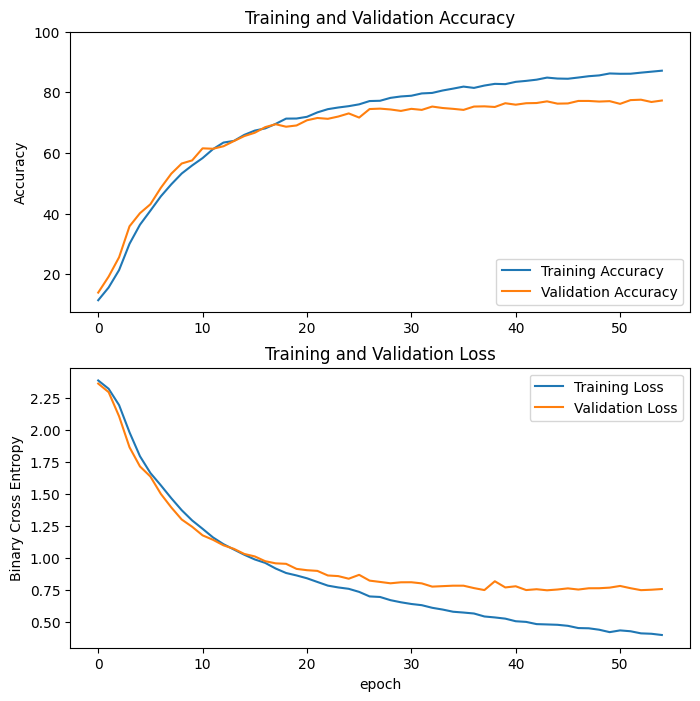

In [115]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),100])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

- Đường Training thể hiện khả năng học của mô hình trên dữ liệu huấn luyện
- Đường Validation phản ánh khả năng tổng quát hóa trên dữ liệu chưa thấy

Kết quả huấn luyện cho thấy mô hình hội tụ ổn định sau một số epoch đầu.
Accuracy trên tập validation đạt mức cao và vượt tập huấn luyện, có lẽ tập train đã khá gần với tổng thể, kiến trúc Transformer đề xuất phù hợp với bài toán phân loại chủ đề.

## 4.2 Đánh giá mô hình trên tập kiểm tra (Test Set)

Sau khi hoàn tất huấn luyện và tinh chỉnh mô hình,
chúng ta tiến hành đánh giá trên tập test.
Tập dữ liệu này hoàn toàn không được sử dụng trong quá trình huấn luyện
nhằm phản ánh chính xác khả năng tổng quát hóa của mô hình.

In [123]:
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

print("========== FINAL TEST RESULT ==========")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

========== FINAL TEST RESULT ==========
Test Loss: 0.9474
Test Accuracy: 74.62%


###Tạo Confusion Matrix


Confusion Matrix cho phép quan sát chi tiết hiệu suất phân loại của mô hình trên từng lớp.  
Thông qua ma trận này, ta có thể:

- Xác định các lớp được mô hình phân loại tốt
- Phát hiện các cặp lớp dễ gây nhầm lẫn
- Đánh giá mức độ cân bằng trong dự đoán

In [119]:
def get_all_preds(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch["input_ids"].to(device)
            labels = batch["label"].to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

In [120]:
import seaborn as sns

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

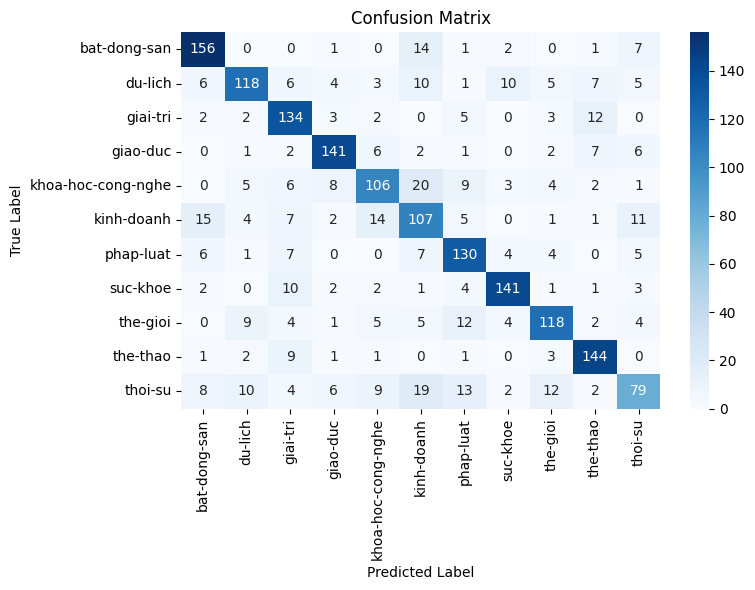

In [122]:
from sklearn.metrics import confusion_matrix

# 1. Predict
y_true, y_pred = get_all_preds(model, test_loader, device)

# 2. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Label name
idx2label = {v: k for k, v in label2idx.items()}
class_names = [idx2label[i] for i in range(len(idx2label))]

# 4. Plot
plot_confusion_matrix(cm, class_names)


Kết quả cho thấy mô hình hoạt động ổn trên đa số các lớp, tuy nhiên vẫn tồn tại một số nhầm lẫn giữa các lớp có nội dung ngữ nghĩa gần nhau.

Lưu trọng số của mô hình

In [113]:
from google.colab import drive
drive.mount('/content/drive')

# Lưu vào Drive
torch.save(model.state_dict(), "/content/drive/MyDrive/text_cls_transformer_v5.pth")

Mounted at /content/drive


Kết quả trên tập test cho thấy hiệu năng cuối cùng của mô hình.
Accuracy cao chứng tỏ mô hình học được các đặc trưng ngữ nghĩa
phù hợp cho bài toán phân loại chủ đề bài báo tiếng Việt.


Mô hình Transformer đề xuất đạt hiệu quả cao trên cả tập validation và test,
cho thấy khả năng tổng quát hóa tốt và kiến trúc phù hợp với bài toán đặt ra.


#5. Ứng dụng mô hình phân loại trong hệ thống gợi ý văn bản

## 5.1 Trích xuất biểu diễn ngữ nghĩa (Sentence Embedding)

Sau khi mô hình Transformer được huấn luyện cho bài toán phân loại văn bản, ta có thể tận dụng các tầng biểu diễn trung gian của mô hình để trích xuất **vector ngữ nghĩa cho mỗi văn bản**.  
Các vector này được sử dụng làm đầu vào cho hệ thống gợi ý dựa trên độ tương đồng nội dung.

### Ý tưởng phương pháp

Quy trình trích xuất sentence embedding được thực hiện qua các bước sau:

1. **Vector hóa văn bản đầu vào**  
   Văn bản được tokenize, ánh xạ sang chỉ số trong từ điển và padding/truncate về cùng độ dài.

2. **Embedding và Transformer Encoder**  
   Văn bản được đưa qua tầng embedding (token + position) và khối Transformer để học biểu diễn ngữ cảnh.

3. **Average Pooling**  
   Áp dụng average pooling theo chiều chuỗi để thu được một vector cố định đại diện cho toàn bộ văn bản.

4. **Chuẩn hóa vector**  
   Vector đầu ra được chuẩn hóa theo chuẩn L2 nhằm phục vụ cho việc tính **Cosine Similarity**.

In [102]:
def get_sentence_embedding(model, word2idx, text, max_len, device):
    # Vectorize text
    ids = vectorize(word2idx, text, max_len)
    ids = torch.tensor([ids], dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        # 1) Embedding + Transformer
        x = model.embd_layer(ids)
        x = model.transformer_layer(x, x, x)

        # 2) Average Pooling (chuyển shape: [1, seq_len, embed_dim] → [1, embed_dim])
        pooled = model.pooling(x.permute(0, 2, 1)).squeeze(0)

        # 3) Chuẩn hóa vector cho cosine similarity
        pooled = F.normalize(pooled, p=2, dim=0)

        return pooled

## 5.2 Xây dựng tập embedding cho toàn bộ tập dữ liệu

Sau khi đã có hàm trích xuất vector ngữ nghĩa cho **một văn bản**, bước tiếp theo là tính embedding cho **toàn bộ tập văn bản** trong tập dữ liệu.  
Các embedding này sẽ được lưu lại và sử dụng trực tiếp trong quá trình tìm kiếm hoặc gợi ý, giúp giảm thời gian tính toán khi có truy vấn mới.


### Ý tưởng thực hiện

- Duyệt qua từng văn bản trong tập dữ liệu
- Với mỗi văn bản: Trích xuất sentence embedding bằng mô hình Transformer đã huấn luyện
- Lưu toàn bộ embedding vào một danh sách để phục vụ cho việc so sánh độ tương đồng

Cách làm này phù hợp với:
- Hệ thống gợi ý dựa trên nội dung (content-based recommendation)
- Bài toán tìm kiếm văn bản tương tự theo ngữ nghĩa

In [103]:
def compute_all_embeddings(model, sentences, word2idx, max_len, device):
    all_embs = []
    for s in sentences:
        emb = get_sentence_embedding(model, word2idx, s, max_len, device)
        all_embs.append(emb)
    return all_embs

## 5.3 Tìm kiếm và gợi ý văn bản dựa trên Cosine Similarity

Sau khi đã xây dựng embedding cho toàn bộ tập dữ liệu,
ta có thể triển khai bài toán **tìm kiếm các văn bản giống nhất với một câu truy vấn**.
Đây là nền tảng của nhiều hệ thống gợi ý và công cụ tìm kiếm ngữ nghĩa hiện nay.


### Cosine Similarity là gì?

Cosine Similarity đo độ tương đồng giữa hai vector trong không gian nhiều chiều
dựa trên **góc giữa hai vector**:

- Giá trị nằm trong khoảng \([-1, 1]\)
- Càng gần **1** → hai văn bản càng giống nhau về mặt ngữ nghĩa
- Phù hợp với embedding đã được chuẩn hóa (L2 normalization)

Trong bài toán này:
- Mỗi văn bản được biểu diễn bằng một vector embedding
- Câu truy vấn cũng được ánh xạ sang cùng không gian vector
- So sánh query với từng văn bản trong tập dữ liệu

In [104]:
def top_k_similar(model, query, corpus, corpus_embs, word2idx, max_len, device, K=5):
    q_emb = get_sentence_embedding(model, word2idx, query, max_len, device)

    similarities = []
    for i, emb in enumerate(corpus_embs):
        sim = torch.cosine_similarity(q_emb, emb, dim=0)
        if sim >= 0.9999:
            continue
        similarities.append((sim.item(), i, corpus[i]))

    similarities.sort(reverse=True, key=lambda x: x[0])
    return similarities[:K]

## 5.4 Xây dựng tập văn bản và embedding cho hệ thống gợi ý

Trước khi thực hiện tìm kiếm hoặc gợi ý nội dung,
ta cần chuẩn bị hai thành phần chính:

- **Corpus**: danh sách toàn bộ văn bản trong tập dữ liệu
- **Corpus Embeddings**: embedding tương ứng với từng văn bản trong corpus

Các embedding này sẽ đóng vai trò như “bộ nhớ ngữ nghĩa”
để so sánh với câu truy vấn của người dùng.

In [105]:
corpus = [text[0] for text in data]      # list các câu
corpus_embs = compute_all_embeddings(model, corpus, vocab, MAX_SEQ_LEN, device)

Tạo dữ liệu test cho các bước đánh giá

In [106]:
titles = ["Phú Quốc sắp có thêm dự án du lịch nghỉ dưỡng gần 1,3 tỷ USD",
          "CEO Nvidia: 'Thật điên rồ khi hạn chế dùng AI'",
          "Bất ngờ khỏi HIV sau khi ghép tế bào gốc",
          "Các bước chăm sóc da đơn giản cho nam giới",
          "Chiếm đoạt hơn 10 tỷ đồng của nhiều người muốn đi Canada làm việc",
          "Tốt nghiệp xuất sắc Bách khoa sau hai năm bỏ học, chạy xe ôm",
          "Một thí sinh ở Hà Nội bị thu hồi bằng tốt nghiệp THPT",
          "Triệu phú 22 tuổi đánh đổi sức khỏe để giàu nhanh",
          "Tạp chí nước ngoài gợi ý trải nghiệm ẩm thực ở Việt Nam"
          ]
descriptions = ["Công ty Cổ phần Enclave Phú Quốc dự kiến triển khai khu nghỉ dưỡng - giải trí phức hợp Enclave Phú Quốc, với tổng mức đầu tư khoảng 34.000 tỷ đồng (gần 1,3 tỷ USD).",
                "CEO Nvidia, yêu cầu nhân viên tăng cường dùng AI, bác bỏ lo ngại công nghệ này đe dọa việc làm và chỉ trích những quản lý tìm cách giảm sử dụng AI.",
                "Bệnh nhân nam 60 tuổi trở thành người thứ 7 trên thế giới hết hoàn toàn virus HIV sau khi ghép tế bào gốc trị ung thư máu.",
                "Với quy trình chăm sóc da gồm làm sạch, dưỡng ẩm, chống nắng và vài lưu ý sau cạo râu, phái mạnh có thể sở hữu làn da khỏe mạnh. ",
                "Dương Văn Đại đầu tư Forex thua lỗ nên bịa chuyện có thể đưa người sang Canada xuất khẩu lao động, làm giả giấy tờ để chiếm đoạt hơn 10 tỷ đồng của 15 người.",
                "Bắt đầu lại từ trường giáo dục thường xuyên sau hai năm bỏ học làm tài xế công nghệ, Hữu Quang đỗ Đại học Bách khoa TP HCM, rồi tốt nghiệp xuất sắc.",
                "Một cựu học sinh trường THPT Đan Phượng bị hủy kết quả, thu hồi bằng vì gian lận, sau gần nửa năm diễn ra kỳ thi tốt nghiệp.",
                "Emil Barr sở hữu hai công ty định giá hơn 20 triệu USD nhờ làm việc 12,5 tiếng mỗi ngày, cắt bỏ mọi quan hệ xã hội và chấp nhận tàn phá cơ thể",
                "Ngoài phở và bánh mì, tạp chí Lonely Planet gợi ý du khách nên thử bún bò Huế, cao lầu, bánh xèo và các món hải sản để cảm nhận trọn vẹn sự đa dạng của ẩm thực Việt. "
                ]
articles = list(zip(titles, descriptions))
print(articles)

[('Phú Quốc sắp có thêm dự án du lịch nghỉ dưỡng gần 1,3 tỷ USD', 'Công ty Cổ phần Enclave Phú Quốc dự kiến triển khai khu nghỉ dưỡng - giải trí phức hợp Enclave Phú Quốc, với tổng mức đầu tư khoảng 34.000 tỷ đồng (gần 1,3 tỷ USD).'), ("CEO Nvidia: 'Thật điên rồ khi hạn chế dùng AI'", 'CEO Nvidia, yêu cầu nhân viên tăng cường dùng AI, bác bỏ lo ngại công nghệ này đe dọa việc làm và chỉ trích những quản lý tìm cách giảm sử dụng AI.'), ('Bất ngờ khỏi HIV sau khi ghép tế bào gốc', 'Bệnh nhân nam 60 tuổi trở thành người thứ 7 trên thế giới hết hoàn toàn virus HIV sau khi ghép tế bào gốc trị ung thư máu.'), ('Các bước chăm sóc da đơn giản cho nam giới', 'Với quy trình chăm sóc da gồm làm sạch, dưỡng ẩm, chống nắng và vài lưu ý sau cạo râu, phái mạnh có thể sở hữu làn da khỏe mạnh. '), ('Chiếm đoạt hơn 10 tỷ đồng của nhiều người muốn đi Canada làm việc', 'Dương Văn Đại đầu tư Forex thua lỗ nên bịa chuyện có thể đưa người sang Canada xuất khẩu lao động, làm giả giấy tờ để chiếm đoạt hơn 10 tỷ

##5.5 Đánh giá và xem xét hiểu quả của hệ thống gợi ý

In [107]:
queries = [normalize_text(article[0] + ' <dis> ' + article[1]) for article in articles]

In [108]:
def predict(model, query, word2idx, max_len, device):
    model.eval()
    with torch.no_grad():
        # 1) vectorize câu
        input_ids = vectorize(word2idx, query, max_len)
        input_ids = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(device)

        # 2) đưa vào model
        logits = model(input_ids)
        if logits.dim() == 1:        # nếu chỉ còn [num_classes]
            logits = logits.unsqueeze(0)

        # 3) softmax để xem xác suất
        probs = F.softmax(logits, dim=1)

        # 4) nhãn dự đoán
        pred_label = probs.argmax(dim=1).item()

        return pred_label, probs.squeeze().cpu().numpy()

In [109]:
import numpy as np

def print_top5(probs, idx2label):
    probs = np.array(probs)

    # lấy top 5 index theo xác suất
    topk = probs.argsort()[-5:][::-1]   # sorted descending

    print("Top 5 nhãn có xác suất cao nhất:")
    for idx in topk:
        print(f"{idx2label[idx]}: {probs[idx]:.6f}")

In [110]:
for query in queries:
    pred_label, probs = predict(model, query, vocab, MAX_SEQ_LEN, device)
    print(query)
    print("Nhãn:", idx2label[pred_label])
    print_top5(probs, idx2label)
    print("______________________________________________________")

phú quốc sắp có thêm dự án du lịch nghỉ dưỡng gần <num><num> tỷ usd <dis> công ty cổ phần enclave phú quốc dự kiến triển khai khu nghỉ dưỡng giải trí phức hợp enclave phú quốc với tổng mức đầu tư khoảng <num> tỷ đồng gần <num><num> tỷ usd
Nhãn: bat-dong-san
Top 5 nhãn có xác suất cao nhất:
bat-dong-san: 0.828492
kinh-doanh: 0.137300
thoi-su: 0.020533
du-lich: 0.006810
khoa-hoc-cong-nghe: 0.003756
______________________________________________________
ceo nvidia thật điên rồ khi hạn chế dùng ai <dis> ceo nvidia yêu cầu nhân viên tăng cường dùng ai bác bỏ lo ngại công nghệ này đe dọa việc làm và chỉ trích những quản lý tìm cách giảm sử dụng ai
Nhãn: khoa-hoc-cong-nghe
Top 5 nhãn có xác suất cao nhất:
khoa-hoc-cong-nghe: 0.947381
kinh-doanh: 0.036177
giao-duc: 0.013766
giai-tri: 0.000931
du-lich: 0.000572
______________________________________________________
bất ngờ khỏi hiv sau khi ghép tế bào gốc <dis> bệnh nhân nam <num> tuổi trở thành người thứ <num> trên thế giới hết hoàn toàn virus

In [111]:
for query in queries:
    print(query)
    results = top_k_similar(model, query, corpus, corpus_embs, vocab, MAX_SEQ_LEN, device)

    for score, idx, text in results:
        print(f"{score:.4f} | {text}")
    print("________________________________________________________________________")

phú quốc sắp có thêm dự án du lịch nghỉ dưỡng gần <num><num> tỷ usd <dis> công ty cổ phần enclave phú quốc dự kiến triển khai khu nghỉ dưỡng giải trí phức hợp enclave phú quốc với tổng mức đầu tư khoảng <num> tỷ đồng gần <num><num> tỷ usd
0.8130 | tỷ suất cho thuê căn hộ tp hcm chạm đáy <dis> tỷ suất cho thuê căn hộ tại tp hcm đang giảm xuống mức thấp kỷ lục khoảng <num><num> bất chấp giá thuê có sự điều chỉnh tăng nhẹ theo batdongsan
0.8048 | hạ tầng liên vùng tạo lực đẩy cho bất động sản đồng nai <dis> vành đai <num> dự án mở rộng cao tốc tp hcm long thành dầu giây định hướng metro thủ thiêm long thành góp phần tạo sức hút cho địa ốc đồng nai
0.8020 | lý do phía tây hà nội thành điểm đến của bất động sản cho thuê <dis> hạ tầng cải thiện điều chỉnh quy hoạch hành chính và sự dịch chuyển của doanh nghiệp thúc đẩy nhu cầu bất động sản cho thuê tại phía tây hà nội
0.8010 | địa ốc đan phượng hưởng lợi hạ tầng phía tây thủ đô <dis> loạt dự án hạ tầng trọng điểm phía tây như đại lộ tây thăn

In [112]:
for i in range(20):
    query = test_data[i][0]
    pred_label, probs = predict(model, query, vocab, MAX_SEQ_LEN, device)
    print(query)
    print("Nhãn:", idx2label[pred_label])
    print_top5(probs, idx2label)

    results = top_k_similar(model, query, corpus, corpus_embs, vocab, MAX_SEQ_LEN, device)

    for score, idx, text in results:
        print(f"{score:.4f} | {text}")
    print("___________________________________________________________")

ba đứa trẻ tử vong dưới hồ <dis> ba cháu nhỏ <num> và <num> tuổi tắm ở hồ tưới cà phê gần nhà bị đuối nước trong đó có hai anh em trưa <date>
Nhãn: thoi-su
Top 5 nhãn có xác suất cao nhất:
thoi-su: 0.433866
phap-luat: 0.239306
suc-khoe: 0.117191
kinh-doanh: 0.085849
bat-dong-san: 0.046891
0.9041 | <num> năm mắc kẹt trong dự án treo <dis> <num> hộ dân ở xóm lựng phường hưng đạo thường xuyên bị ngập lụt nhà cửa xuống cấp nhưng không được sửa chữa xây mới
0.8916 | nghi phạm hãm hại con của bạn ra đầu thú <dis> sau khi thực hiện hành vi đồi bại với con gái <num> tuổi của bạn nhậu lê trí tâm anh <num> tuổi đến công an đầu thú
0.8916 | dụ dỗ bé gái <num> tuổi vào phòng khách sạn <dis> trần minh tuấn <num> tuổi đưa người yêu nhí hơn <num> tuổi đến phòng khách sạn dụ dỗ quan hệ tình dục
0.8887 | hồi sinh món chả cua đồng <dis> chị trần thị hậu ở xã hưng nguyên khôi phục món chả cua đồng đã thất truyền hơn <num> năm xây dựng thành sản phẩm ocop <num> sao
0.8673 | sao nhí reply <num> sau <num> n

In [ ]:
print("Train sample:", train_data[:5])
print("Val sample:", val_data[:5])

Train sample: [('điểm nhấn kiến trúc nội thất căn hộ cao cấp diamond sky <dis> <num> căn hộ diamond sky có kiến trúc bán cổ điển cùng nội thất cao cấp theo tiêu chuẩn châu âu hướng đến nhóm khách hàng có yêu cầu cao về không gian sống', 'bat-dong-san'), ('truy tìm nghi phạm đâm gục <num> thanh niên trước cổng quán karaoke <dis> do mâu thuẫn trước cổng quán karaoke hai thanh niên ở kon tum đã bị đâm trọng thương trong đó <num> người đã tử vong cơ quan chức năng đang truy tìm nghi phạm', 'phap-luat'), ('buv vào top <num> quy trình tuyển sinh tốt nhất năm <num> <dis> trường đại học anh quốc việt nam buv đươc công nhân là một trong ba trường hàng đầu thê giơi về quy trình tuyển sinh tại giải thưởng global student satisfaction awards <num>', 'giao-duc'), ('đặc sản màu đỏ rực ở miền tây hiếm thấy ngoài bắc giá cao vẫn hút khách <dis> tháng <num><num> hằng năm tại các sạp trái cây ở tphcm cần thơ du khách dễ bắt gặp loại quả giống trái đào vỏ đỏ rực phủ lông tơ trắng tỏa hương thơm dịu nhẹ', 

#6. Nâng cấp mô hình phân loại với các Pretrained Models

## Pretrained Language Model là gì?

**Pretrained Language Model** là các mô hình ngôn ngữ được huấn luyện trước trên tập dữ liệu văn bản rất lớn nhằm học các đặc trưng chung của ngôn ngữ như:
- Từ vựng
- Ngữ pháp
- Ngữ nghĩa
- Ngữ cảnh giữa các từ trong câu

Thay vì giải quyết một bài toán cụ thể, các mô hình này được huấn luyện theo các mục tiêu tổng quát như dự đoán từ bị che (Masked Language Modeling) hoặc dự đoán câu tiếp theo.


## Vì sao pretrained model hiệu quả?

Việc sử dụng pretrained model mang lại nhiều lợi ích quan trọng:

- **Tận dụng tri thức ngôn ngữ sẵn có**: mô hình đã học được cách biểu diễn ngữ nghĩa từ hàng triệu câu
- **Giảm lượng dữ liệu cần thiết** cho bài toán cụ thể
- **Giảm thời gian huấn luyện** so với huấn luyện từ đầu
- **Tăng khả năng tổng quát hóa**, đặc biệt khi dữ liệu huấn luyện không lớn

Nhờ đó, pretrained model thường cho kết quả vượt trội so với các mô hình truyền thống hoặc mô hình huấn luyện từ đầu.

##6.1 Sử dụng SBERT cho bài toán phân loại văn bản tiếng Việt

Thay vì huấn luyện mô hình ngôn ngữ từ đầu, ta có thể fine-tuning lại các pretrained model để nâng cao kết quả dự đoán. ta sử dụng mô hình SBERT có tên
**paraphrase-multilingual-MiniLM-L12-v2**
do Sentence-Transformers cung cấp.


### Lý do chọn mô hình



- Không yêu cầu tài nguyên tính toán lớn
- Phù hợp với các bài toán phân loại văn bản quy mô vừa và nhỏ

### Phương pháp tiếp cận

Đóng băng toàn bộ các layer của model, chỉ tinh chỉnh lại 2 layer cuối cùng, rồi kết hợp với các tầng fully-connected đã được thiết kế để dự đoán nhãn

### Hướng phát triển


Trong tương lai, có thể cải thiện mô hình bằng cách:

- Dùng các trọng số của model SBERT như giá trị khởi tạo, thêm classifier và train lại toàn bộ
- Thử nghiệm các kiến trúc classifier khác nhau

Bên cạnh việc sử dụng embedding được huấn luyện từ bài toán phân loại,
một hướng tiếp cận phổ biến và hiệu quả hơn là sử dụng
**các mô hình embedding đã được tiền huấn luyện** trên tập dữ liệu lớn.

Các mô hình này học trực tiếp mối quan hệ ngữ nghĩa giữa các câu,
đặc biệt phù hợp cho bài toán:
- Tìm kiếm ngữ nghĩa (Semantic Search)
- Hệ thống gợi ý nội dung
- So khớp câu hỏi – văn bản


In [ ]:
from sentence_transformers import SentenceTransformer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sent_model = SentenceTransformer(
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    device=device
)

# Freeze toàn bộ
for param in sent_model.parameters():
    param.requires_grad = False

# Unfreeze 2 layer Transformer cuối
for layer in sent_model._modules["0"].auto_model.encoder.layer[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

sent_model.train()

class MyDataset(Dataset):
    def __init__(self, data, label2idx):
        self.texts = [x[0] for x in data]
        self.labels = [x[1] for x in data]
        self.label2idx = label2idx

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            "text": self.texts[idx],
            "label": torch.tensor(
                self.label2idx[self.labels[idx]],
                device=device
            )
        }

train_dataset = MyDataset(train_data, label2idx)
val_dataset   = MyDataset(val_data, label2idx)
test_dataset  = MyDataset(test_data, label2idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16)
test_loader  = DataLoader(test_dataset, batch_size=16)

embedding_dim = 384
num_classes = 11

class Classifier(nn.Module):
    def __init__(self, embedding_dim, num_classes, hidden_dim=256, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

classifier = Classifier(
    embedding_dim,
    num_classes,
    hidden_dim=256,
    dropout=0.2
).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([
    {
        "params": filter(lambda p: p.requires_grad, sent_model.parameters()),
        "lr": 2e-5    # encoder (nhỏ)
    },
    {
        "params": classifier.parameters(),
        "lr": 1e-3    # classifier
    }
])

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 10

for epoch in range(1, num_epochs + 1):
    # ================= TRAIN =================
    sent_model.train()
    classifier.train()

    total_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        texts = batch["text"]
        labels = batch["label"]

        optimizer.zero_grad()

        # ⚠ encode trong loop để có gradient
        embeddings = sent_model.encode(
            texts,
            convert_to_tensor=True,
            device=device
        )

        outputs = classifier(embeddings)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ================= VALID =================
    sent_model.eval()
    classifier.eval()

    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
            texts = batch["text"]
            labels = batch["label"]

            embeddings = sent_model.encode(
                texts,
                convert_to_tensor=True,
                device=device
            )

            outputs = classifier(embeddings)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch}/{num_epochs}] | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
    )



Epoch [1/10] | Train Loss: 0.8710, Train Acc: 74.53% | Val Loss: 0.6571, Val Acc: 78.14%
Epoch [2/10] | Train Loss: 0.6403, Train Acc: 79.34% | Val Loss: 0.6271, Val Acc: 80.33%
Epoch [3/10] | Train Loss: 0.5848, Train Acc: 80.74% | Val Loss: 0.6060, Val Acc: 79.30%
Epoch [4/10] | Train Loss: 0.5556, Train Acc: 81.64% | Val Loss: 0.5912, Val Acc: 80.12%
Epoch [5/10] | Train Loss: 0.5213, Train Acc: 82.60% | Val Loss: 0.5818, Val Acc: 80.74%
Epoch [6/10] | Train Loss: 0.4987, Train Acc: 83.27% | Val Loss: 0.5736, Val Acc: 81.15%
Epoch [7/10] | Train Loss: 0.4646, Train Acc: 84.27% | Val Loss: 0.5709, Val Acc: 80.47%
Epoch [8/10] | Train Loss: 0.4369, Train Acc: 85.16% | Val Loss: 0.5657, Val Acc: 80.95%
Epoch [9/10] | Train Loss: 0.4097, Train Acc: 86.18% | Val Loss: 0.5605, Val Acc: 80.95%
Epoch [10/10] | Train Loss: 0.3911, Train Acc: 86.48% | Val Loss: 0.5634, Val Acc: 81.43%


###Đánh giá kết quả

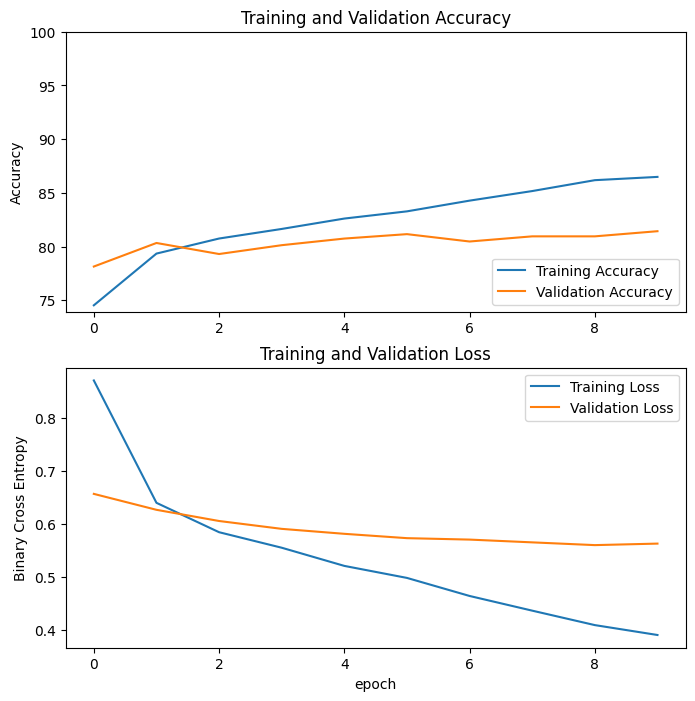

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),100])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
def evaluate_on_test(sent_model, classifier, test_loader, criterion, device):
    sent_model.eval()
    classifier.eval()

    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for batch in test_loader:
            texts = batch["text"]
            labels = batch["label"]

            # Encode text -> embedding
            embeddings = sent_model.encode(
                texts,
                convert_to_tensor=True,
                device=device
            )

            outputs = classifier(embeddings)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    test_loss /= len(test_loader)
    test_acc = 100.0 * test_correct / test_total

    return test_loss, test_acc

test_loss, test_acc = evaluate_on_test(
    sent_model,
    classifier,
    test_loader,
    criterion,
    device
)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.6803, Test Accuracy: 79.89%


##6.2 Fine-tuning PhoBERT cho bài toán phân loại văn bản tiếng Việt


### Lý do chọn PhoBERT

**PhoBERT** là mô hình ngôn ngữ dựa trên kiến trúc **RoBERTa**, được huấn luyện trước trên tập dữ liệu lớn tiếng Việt.  
So với các mô hình đa ngôn ngữ, PhoBERT có nhiều ưu điểm:

- Hiểu tốt ngữ cảnh và cấu trúc tiếng Việt
- Hiệu quả cao cho các bài toán NLP tiếng Việt
- Phù hợp với fine-tuning trên tập dữ liệu vừa và nhỏ

Do đó, PhoBERT được lựa chọn làm mô hình nền tảng trong bài toán này.


### Phương pháp tiếp cận tương tự model Sentence Transformer

In [ ]:
from transformers import AutoTokenizer, AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_NAME = "vinai/phobert-base"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
phobert = AutoModel.from_pretrained(MODEL_NAME).to(device)

# Freeze toàn bộ
for param in phobert.parameters():
    param.requires_grad = False

# Unfreeze 2 layer cuối (nhẹ)
for layer in phobert.encoder.layer[-2:]:
    for param in layer.parameters():
        param.requires_grad = True

phobert.train()

class MyDataset_(Dataset):
    def __init__(self, data, label2idx, max_len=128):
        self.texts = [x[0] for x in data]
        self.labels = [x[1] for x in data]
        self.label2idx = label2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0).to(device),
            "attention_mask": encoding["attention_mask"].squeeze(0).to(device),
            "label": torch.tensor(
                self.label2idx[self.labels[idx]],
                device=device
            )
        }

train_dataset = MyDataset_(train_data, label2idx)
val_dataset   = MyDataset_(val_data, label2idx)
test_dataset  = MyDataset_(test_data, label2idx)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4)
test_loader  = DataLoader(test_dataset, batch_size=4)

def mean_pooling(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    summed = torch.sum(last_hidden_state * mask, dim=1)
    counts = torch.clamp(mask.sum(dim=1), min=1e-9)
    return summed / counts

embedding_dim = 768   # PhoBERT-base
num_classes = 11

class Classifier(nn.Module):
    def __init__(self, embedding_dim, num_classes, hidden_dim=256, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

classifier = Classifier(
    embedding_dim,
    num_classes
).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([
    {
        "params": filter(lambda p: p.requires_grad, phobert.parameters()),
        "lr": 2e-5     # encoder
    },
    {
        "params": classifier.parameters(),
        "lr": 1e-3     # classifier
    }
])

num_epochs = 5

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    # ================= TRAIN =================
    phobert.train()
    classifier.train()

    total_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]

        optimizer.zero_grad()

        outputs = phobert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        embeddings = mean_pooling(
            outputs.last_hidden_state,
            attention_mask
        )

        logits = classifier(embeddings)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(logits, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ================= VALID =================
    phobert.eval()
    classifier.eval()

    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            labels = batch["label"]

            outputs = phobert(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            embeddings = mean_pooling(
                outputs.last_hidden_state,
                attention_mask
            )

            logits = classifier(embeddings)
            loss = criterion(logits, labels)

            val_loss += loss.item()
            _, preds = torch.max(logits, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch}/{num_epochs}] | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%"
    )


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Epoch [1/5] | Train Loss: 0.7620, Train Acc: 75.81% | Val Loss: 0.5789, Val Acc: 82.18%
Epoch [2/5] | Train Loss: 0.5229, Train Acc: 83.08% | Val Loss: 0.5924, Val Acc: 81.36%
Epoch [3/5] | Train Loss: 0.4531, Train Acc: 85.04% | Val Loss: 0.5853, Val Acc: 82.66%
Epoch [4/5] | Train Loss: 0.3751, Train Acc: 87.59% | Val Loss: 0.5260, Val Acc: 84.92%
Epoch [5/5] | Train Loss: 0.3257, Train Acc: 89.07% | Val Loss: 0.5216, Val Acc: 85.74%


### Đánh giá kết quả

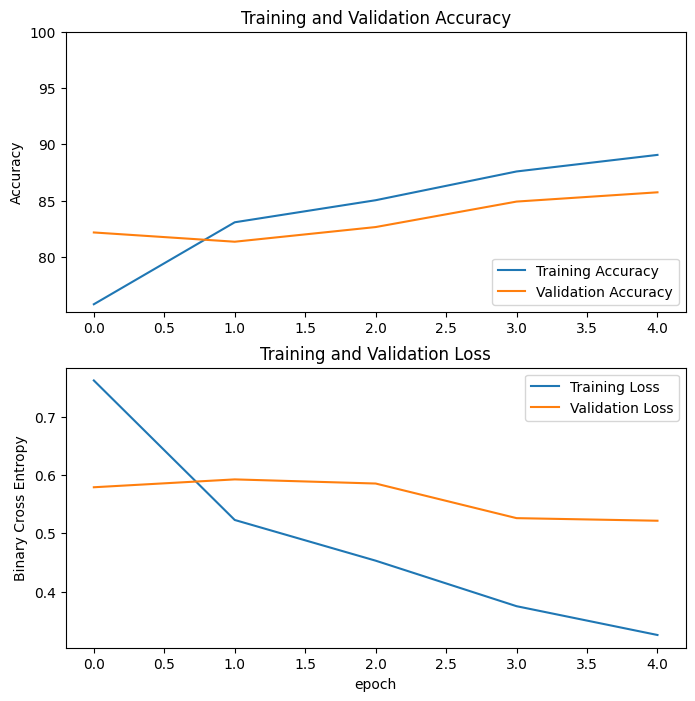

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),100])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
def evaluate_test_phobert(phobert, classifier, test_loader, criterion, device):
    """
    Đánh giá mô hình PhoBERT + classifier trên tập test
    Trả về: test_loss, test_accuracy
    """
    phobert.eval()
    classifier.eval()

    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            labels = batch["label"]

            outputs = phobert(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Mean pooling để lấy sentence embedding
            embeddings = mean_pooling(
                outputs.last_hidden_state,
                attention_mask
            )

            logits = classifier(embeddings)
            loss = criterion(logits, labels)

            test_loss += loss.item()

            _, preds = torch.max(logits, dim=1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    test_loss /= len(test_loader)
    test_acc = 100.0 * test_correct / test_total

    return test_loss, test_acc

test_loss, test_acc = evaluate_test_phobert(
    phobert,
    classifier,
    test_loader,
    criterion,
    device
)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.6171, Test Accuracy: 84.89%


#7. Mở rộng hệ thống gợi ý với Pretrained Model

Bên cạnh việc sử dụng embedding được huấn luyện từ bài toán phân loại,
một hướng tiếp cận phổ biến và hiệu quả hơn là sử dụng
**các mô hình embedding đã được tiền huấn luyện** trên các pretrained model. Ở đây ta sẽ sử dụng lại mô hình
**paraphrase-multilingual-MiniLM-L12-v2**
do Sentence-Transformers cung cấp vì tính gọn nhẹ của nó.

## 7.1 Xây dựng hàm trích xuất embedding

In [ ]:
def get_sentence_embedding_use_pretrain(sentence):
    """
    Input: string
    Output: torch tensor shape (embedding_dim,)
    """
    emb = sent_model.encode(
        sentence,
        convert_to_tensor=True,
        normalize_embeddings=True
    )
    return emb

##7.2 Xây dựng các hàm tương tự với hệ thống sử dụng embedding của bài toán phân loại

In [ ]:
def top_k_similar_use_pretrain(corpus_embs, K=5):
    q_emb = get_sentence_embedding_use_pretrain(query)

    similarities = []
    for i, emb in enumerate(corpus_embs):
        sim = torch.cosine_similarity(q_emb, emb, dim=0)

        if sim >= 0.9999:
            continue
        similarities.append((sim.item(), i, corpus[i]))

    similarities.sort(reverse=True, key=lambda x: x[0])
    return similarities[:K]

def compute_all_embeddings_use_pretrain(sentences):
    all_embs = []
    for s in sentences:
        emb = get_sentence_embedding_use_pretrain(s)
        all_embs.append(emb)
    return all_embs

In [ ]:
corpus_embs_pretrain = compute_all_embeddings_use_pretrain(corpus)

##7.3 Đánh giá kết quả

In [ ]:
for query in queries:
    print(query)
    results = top_k_similar_use_pretrain(corpus_embs_pretrain)

    for score, idx, text in results:
        print(f"{score:.4f} | {text}")
    print("________________________________________________________________________")

phú quốc sắp có thêm dự án du lịch nghỉ dưỡng gần <num><num> tỷ usd <dis> công ty cổ phần enclave phú quốc dự kiến triển khai khu nghỉ dưỡng giải trí phức hợp enclave phú quốc với tổng mức đầu tư khoảng <num> tỷ đồng gần <num><num> tỷ usd
0.7336 | hà tĩnh sắp có khu du lịch sinh thái gần <num> tỷ đồng <dis> khu du lịch sinh thái biển xuân hội với tổ hợp nghỉ dưỡng cao cấp gồm khách sạn công viên quảng trường biển tổng vốn đầu tư gần <num> tỷ đồng
0.6472 | quảng trị đón <num> dự án quy mô hơn <num> nghìn tỷ đồng <dis> với tổng diện tích lên tới gần <num> ha ba khu đô thị sở hữu mọi lợi thế của những quần thể du lịch vui chơi giải trí nghỉ dưỡng và an cư được đầu tư bài bản đa kết nối hạ tầng đa dạng sản phẩm và đa chiều trải nghiệm
0.6368 | bất động sản phú quốc đón sóng apec <num> <dis> nhiều dự án hạ tầng du lịch nghỉ dưỡng gấp rút triển khai nhằm đón sóng thị trường khi phú quốc đăng cai apec <num>
0.6315 | khu du lịch quốc gia mũi né sẽ có đường ven biển <num> km <dis> khu du lịch q

In [ ]:
for i in range(20):
    query = test_data[i][0]
    print(query)
    results = top_k_similar_use_pretrain(corpus_embs_pretrain)

    for score, idx, text in results:
        print(f"{score:.4f} | {text}")
    print("___________________________________________________________________")

ba đứa trẻ tử vong dưới hồ <dis> ba cháu nhỏ <num> và <num> tuổi tắm ở hồ tưới cà phê gần nhà bị đuối nước trong đó có hai anh em trưa <date>
0.7452 | vỡ hồ chứa ở lâm đồng <num> người trong một gia đình bị cuốn trôi <dis> sau trận mưa lớn trong đêm một hồ chứa nước của trang trại nuôi gà ở xã tuy phong tỉnh lâm đồng bị vỡ khiến ba người trong một gia đình bị nước cuốn trôi đến sáng nay lực lượng chức năng đã tìm thấy thi thể bé gái
0.6726 | hai bé sinh đôi <num> tháng tuổi đuối nước không qua khỏi <dis> hai bé sinh đôi <num> tháng tuổi được gia đình phát hiện đuối nước dưới ao khi đưa lên bờ cả hai trẻ đã nguy kịch được đưa vào bệnh viện cấp cứu nhưng không qua khỏi
0.6550 | nam thanh niên tử vong <num> người cấp cứu sau bữa ăn cá biển <dis> ba người đàn ông ra biển đánh bắt hải sản về nấu và ăn chung khiến <num> người tử vong <num> người phải cấp cứu
0.6468 | vỡ hồ chứa trên núi ở lâm đồng nhiều người bị cuốn trôi <dis> hồ chứa nước do doanh nghiệp đắp trên núi ở xã tuy phong bình th